In [1]:
# start by importing the necessities 
import numpy as np 
from astropy.io import fits 
from matplotlib import pyplot as plt 

In [2]:
# open fits file
ffile = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/leor1.fits')

In [3]:
fdata = ffile[0].data 
fheader=ffile[0].header

# Bias subtraction and trimming

These raw CCD data have a bias strip on the side. The purpose of this strip is to measure a zero point that can be subtracted from each row. 

First, we have to figure out where the bias strip is. You can either look at the image in ds9 and see that it is over at the highest 40 pixels or so in x. 

We can also plot a slice through the image with python:

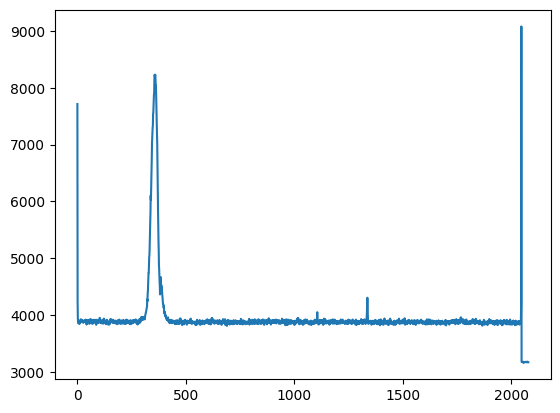

In [4]:
plt.plot(fdata[1000,:])

We can zoom in on our slice to see more precisely where the bias strip is. 

(2000.0, 2100.0)

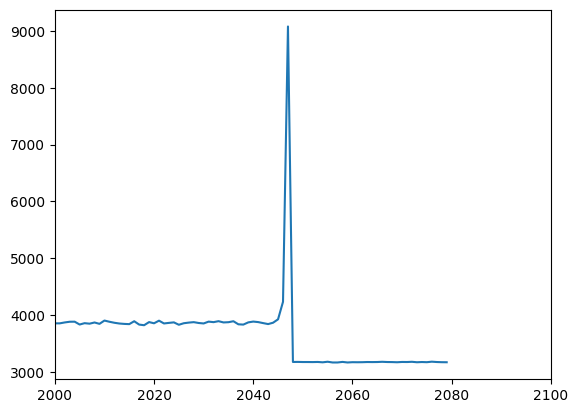

In [5]:
plt.plot(fdata[1000,:])
plt.xlim([2000,2100])

Carefully inspect the plot to identify where the data end and the bias strip begins. 

It looks like a good bias section is x = 2050 through 2079 inclusive.

We should also trim the image and only keep the range x = 5 through 2045 and y = 3 through 2047. 

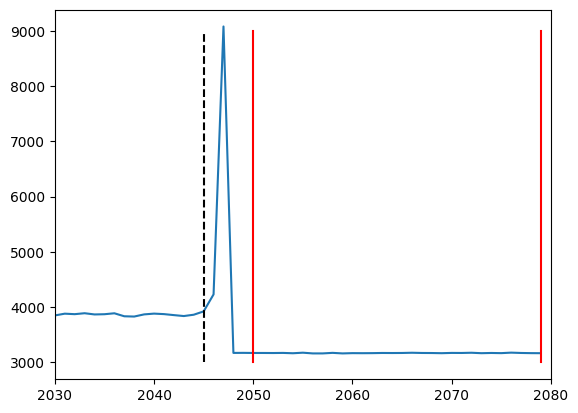

In [6]:
# plot the data 
plt.plot(fdata[1000,:])
plt.xlim([2030,2080])

# visualize our threshold values 
# the end of the data
plt.plot([2045,2045], [3000,9000], color='black', linestyle='dashed')
# the bias strip 
plt.plot([2050,2050], [3000,9000], color='red')
plt.plot([2079,2079], [3000,9000], color='red')

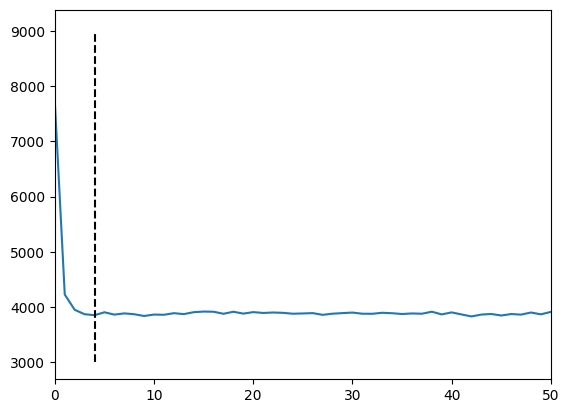

In [7]:
# plot the data 
plt.plot(fdata[1000,:])
plt.xlim([0,50])

# visualize our threshold values 
# the end of the data
plt.plot([4,4], [3000,9000], color='black', linestyle='dashed')

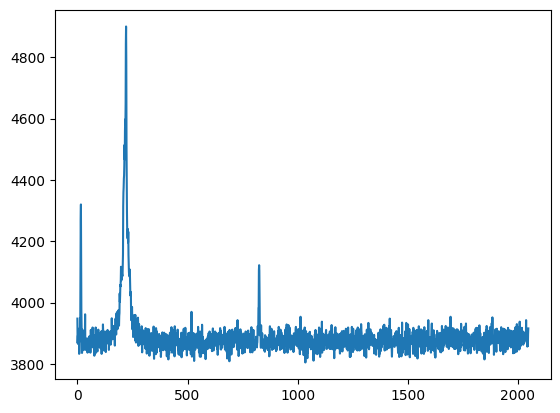

In [8]:
# aaand a slice in y 

# plot the data 
plt.plot(fdata[:,500])


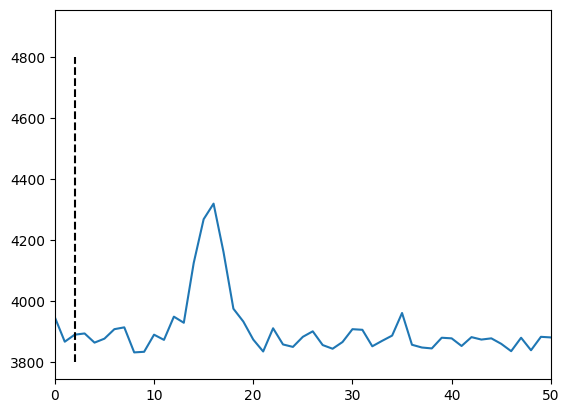

In [9]:
# y limits -- zooming in on the lower end 

# plot the data 
plt.plot(fdata[:,500])
plt.xlim([0,50])

plt.plot([2,2], [3800,4800], color='black', linestyle='dashed')

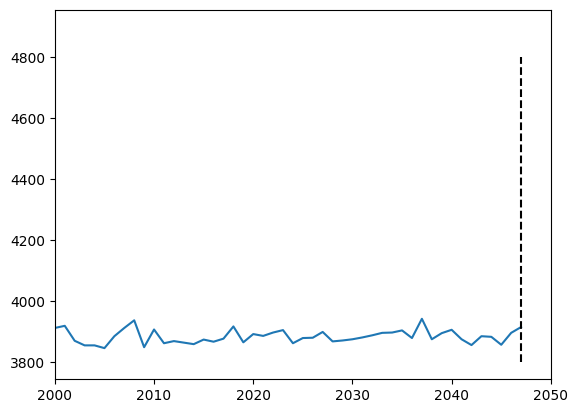

In [10]:
# y limits -- zooming in on the upper end 

# plot the data 
plt.plot(fdata[:,500])
plt.xlim([2000,2050])

plt.plot([2047,2047], [3800,4800], color='black', linestyle='dashed')

To keep things straight, and in case we’d like to change them later, let’s define the following limits for trimming and for bias extraction, in image coordinates:

In [11]:
x1 = 4     # first good pixel in x after trim
x2 = 2045  # last pixel to include in x after trim

y1 = 2     # first good pixel in y after trim
y2 = 2047  # last pixel to include in y after trim

bx1 = 2050 # first pixel of bias section
bx2 = 2080 # last pixel of bias section

Now we extract the portion of the image that we want to keep:

In [12]:
ndata=fdata[y1:y2,x1:x2] #grabs the good section, but still need to subtract bias

Now we want to subtract the bias from each row of the data. You can do this with a for loop that does the computation line-by-line. 

In [13]:
ndata_rm_bias = np.zeros(ndata.shape)

for y in range(y1,y2):
    ndata_rm_bias[y-y1,:] = ndata[y-y1,:] - np.median(fdata[y,bx1:bx2])

Loops can be slooooow and painful for large data. We can accomplish the same thing with a little array manipulation instead. 

In [14]:
row_bias = np.median(fdata[y1:y2,bx1:bx2], axis=1)
bias = np.tile(row_bias[:,np.newaxis], (1, ndata.shape[1]))

ndata_no_bias = ndata - bias 

We can check that these two approaches accomplished the same thing by taking the difference. If all went well, we should find zeros everywhere. 

In [15]:
test = ndata_rm_bias - ndata_no_bias

In [16]:
test 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(2045, 2041)

# Flat field correction

The flatfields for the Leo images have already been trimmed and bias-corrected using the steps described in the previous section. 

These flat images are named ‘rflat.fits’ for the r filter, and similarly for the other filters. 

In [26]:
rflat = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/rflat.fits')[0].data

All the individual flat fields for each filter have been coadded together and normalized. You can (should!) check this by making sure that the average value of the pixels in the flat image is ∼1.

0.99972177

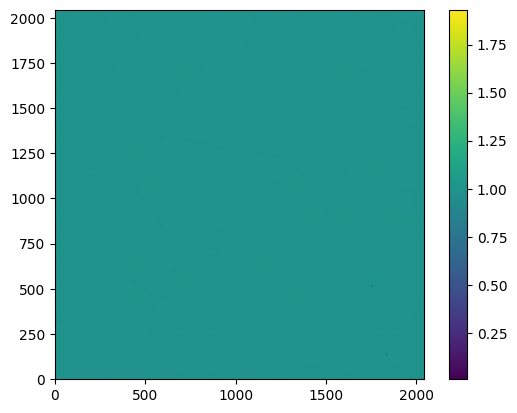

In [25]:
plt.imshow(rflat, origin='lower')
plt.colorbar()

rflat.mean()

Now we just divide the image by the flat field. 

In [27]:
ndata_ff = ndata_no_bias / rflat

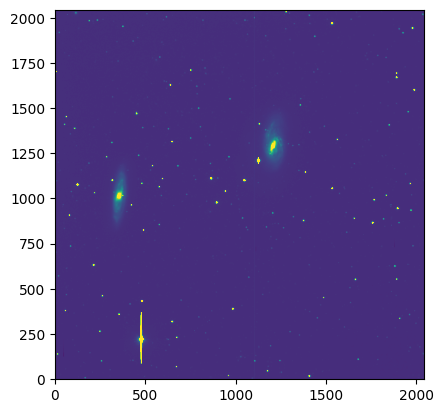

In [33]:
plt.imshow(ndata_ff, origin='lower', vmin=50, vmax=5000)

# update the header and save the processed data

We should update the header to store the trim section and bias section we used, then write the data to a new file.

In [40]:
nheader = fheader # copy the original header
nheader['BIASSEC'] = "["+str(bx1)+":"+str(bx2)+","+str(y1)+":"+str(y2)+"]"
nheader['TRIMSEC'] = "["+str(x1)+":"+str(x2)+","+str(y1)+":"+str(y2)+"]"

Note the formatting. If were to just put quotes around the expression we used to extract the subarray, eg 
nheader['TRIMSEC'] = "[x1:x2,y1:y2]" 
we would end up with *exactly* that statement in the header. 

To get the numerical values we actually used, we have to change the data type from an integer to a string. We can check we did this correctly by printing the header. 

In [41]:
nheader

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2080 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2016-04-12T04:26:46' / Date FITS file was generated                  
IRAF-TLM= '2020-02-02T22:03:22' / Time of last modification                     
OBJECT  = 'm65/66-r'           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Finally, save the processed array to a new file. To make life easier in the future, pick a filename that tells you someting about the processing you've already done to the data. 

In [42]:
fits.writeto("leor1_ff.fits", ndata_ff, nheader, overwrite=True)